# Week 2 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. 

This week, we ask you to build a corpus for preliminary analysis and articulate what your sample represents in context of your final project. We begin by exploring how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [1]:
pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

  Cloning git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git to /private/var/folders/1s/smh2hpds5dx3qkk3b1j6x5dw0000gn/T/pip-req-build-locv4_an


Note: you may need to restart the kernel to use updated packages.


In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch the Domain of your Project*</span>

<span style="color:red">In the two cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words) and **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words)? [**Note**: your individual or collective project can change over the course of the quarter if new data and/or analysis opportunities arise or if old ones fade away.]

## ***What?*** 
NOTE: I will be working in a team with classmates Roberto Barroso-Luque and Linh Dinh for this project.


I am interested in exploring the relationship between US presidential rhetoric surrounding climate change, climate-related executive orders, and how the public perceives these orders. I plan to incorporate three corpuses: 1) transcripts from presidential speeches, 2) executive orders, and 3) climate-related news from the NOW corpus. We choose to consider the role of the president and not other political actors because we believe the president has great influence over public perception of climate change. 


We are interested in questions such as: when a president issues a policy that results in environmental de-regulations, do his speeches focus on creating jobs in the energy sector rather than on trying to justify or deny the environmental harm? Adding on the layer of news coverage of climate talk and policy could answer questions such as what makes climate rhetoric more or less convincing. Specifically, I’d be interested in whether there are presidents who promote similar climate policies yet garner different levels of media support for those policies (i.e., whether it is possible to make a single policy more or less appealing through different framings). 

## ***Why?***
One question of consequence is how much sway presidential rhetoric has public discourse (as manifested in media coverage) over climate change. If the president denies climate change, or chooses to talk about “clean coal” instead of pollution, how does the media subsequently discuss climate change? Does climate coverage change based on the extent of a source’s ideological alignment with the president? Understanding how much of a role the president plays in public opinion on environmental issues reflects how much power in general the president has. 
There is a narrative that the Republican Party’s has become more against climate regulation over time, and it would be interesting to see whether speeches and executive orders of Republican presidents reveal any truth in this. Because news media is a major informational channel, the amount of influence a president has over media coverage can determine the president’s (indirect) influence over the average person. These results could also help identify coded climate-related language and allow people to make sense of the practical implications of buzzword-laden communications as revealed by policies enacted through executive orders. Identifying frameworks that dominate climate change discourse across presidencies is important because it reveals the context within which people form opinions.


## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

We will examine speeches and executive orders and see how presidents present and justify their executive orders through speech, and evaluate fluctuations in media coverage surrounding these events. We will limit our analysis to Clinton onward; future scaling could incorporate previous presidents as well. Arguably, the composition of the House and Senate has more influence over national climate legislation (and policy in general) than the president, but we believe an administration’s attitudes toward environmental policy can set a tone for the nation and thus merits analysis. 


One limitation is that attempting to evaluate the impact of presidential rhetoric on media coverage of climate change assumes the media is paying attention to these speeches. We intend to evaluate media coverage of the environment two weeks before and after a presidential speech or executive order. Because not mentioning terms such as climate change and global warming when talking about the environment (as well as the extent to which sources cover climate change at various points in time) is itself important, it will be challenging to assess news fluctuations. Further, we are limiting our study to formal speeches and not other forms of communication (i.e., Tweets) through which presidents may reach more of the American public. Future iterations could incorporate a wider array of presidential communications.


# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [3]:
%%html
<img source="loopdesign.png">

[Click here for loop design](loopdesign.png)

In [4]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [5]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [6]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [7]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [8]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


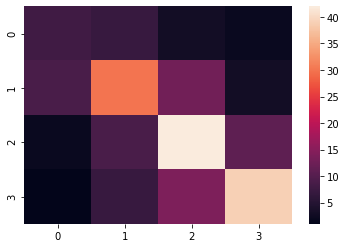

In [9]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [10]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [11]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [12]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [13]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [14]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


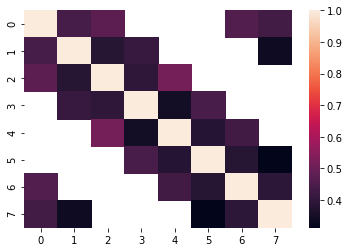

In [15]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [16]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [17]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [18]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

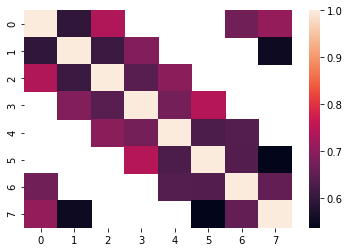

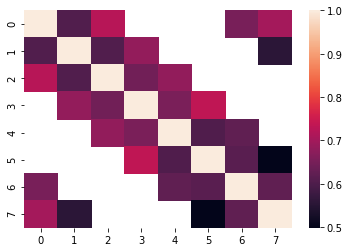

In [19]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [20]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Your turn*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides in the Assignment link on Canvas, or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

I made a survey on MTurk that sampled excerpts of speeches from the past seven presidents preceding Biden and asked respondents to rate on a Likert-style 5-point scale how much they perceived the speaker view fighting climate change as a priority (1: very low priority, 2: low priority, 3: medium priority, 4: high priority, 5: very high priority).

In [131]:
import pandas as pd

In [132]:
df = pd.read_csv('/Users/lilygrier/Documents/Grad_School/Computational Content Analysis/Content Analysis_January 28, 2021_09.47.csv', encoding = 'unicode_escape')

In [133]:
# fix Clinton typo
df = df.rename(columns={'Cinton': 'Clinton'})

In [134]:
results = df[['Clinton', 'Bush Sr.', 'Bush Jr.', 'Carter', 
              'Reagan', 'Obama', 'Trump']]

In [135]:
# drop first two rows of metadata to keep results
results = results.iloc[2:, :].reset_index(drop=True)

In [136]:
# convert to numpy array
results = results.to_numpy(dtype=np.float64)

In [137]:
results = results.T

In [138]:
anno = AnnotationsContainer.from_array(results)

In [139]:
anno.annotations

array([[2, 4, 4, 4, 4, 3, 3, 3, 1, 4, 3, 3, 3, 1, 3, 3, 3, 2, 3, 2, 4, 3,
        3, 3],
       [2, 4, 4, 4, 4, 4, 2, 3, 2, 2, 3, 4, 3, 2, 3, 2, 1, 3, 3, 2, 4, 4,
        4, 3],
       [3, 3, 1, 3, 2, 3, 4, 3, 3, 2, 2, 4, 4, 4, 1, 4, 3, 4, 2, 2, 4, 3,
        4, 2],
       [2, 0, 3, 1, 2, 1, 1, 3, 3, 3, 2, 4, 1, 4, 2, 4, 3, 3, 2, 2, 4, 4,
        3, 2],
       [0, 0, 0, 0, 0, 0, 1, 3, 3, 4, 4, 3, 0, 3, 3, 3, 2, 2, 3, 2, 4, 3,
        2, 2],
       [3, 4, 4, 4, 2, 3, 4, 4, 2, 3, 3, 4, 3, 3, 2, 3, 3, 3, 3, 2, 4, 4,
        3, 3],
       [0, 0, 0, 1, 0, 0, 0, 4, 1, 3, 1, 4, 0, 0, 1, 2, 3, 3, 3, 2, 4, 3,
        1, 1]])

In [140]:
anno.labels

[1.0, 2.0, 3.0, 4.0, 5.0]

Now that we have our annotation object, we can calculate some statistics.

In [141]:
pyanno.measures.agreement.labels_frequency(anno.annotations,5)

array([0.0952381 , 0.0952381 , 0.20238095, 0.35714286, 0.25      ])

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 1.]]


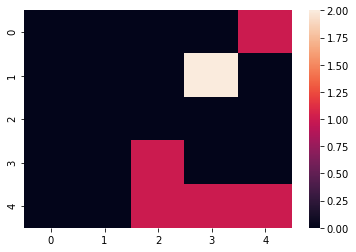

In [142]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,3], 
                                               anno.annotations[:,9],5)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [143]:
scotts_pi(anno.annotations[:,3], anno.annotations[:,9])

-0.15068493150684925

In [144]:
fleiss_kappa(anno.annotations[::])

0.029395834359151083

In [145]:
krippendorffs_alpha(anno.annotations[::])

0.18458631857885976

In [146]:
cohens_kappa(anno.annotations[:,3], anno.annotations[:,9])

-0.04999999999999999

The above matrix, as well as Scott's pi and Cohen's kappa, reveal inter-coder agreement for respondents 3 and 9. As seen in the confusioin matrix, these respondents have relatively low levels of agreement, which is reflected in the negative values of Scott's pi and Cohen's kappa for those two respondents. Fleiss's kappa and Krippendorf's alpha show agreement across all coders in the sample, which is relatively low. The pairwise matrix below also reflects this lack of agreement. Given the question was framed in terms of individual perception and there wasn't a correct answer, this lack of agreement is not surprising, though is larger than I expected it would be.

In [147]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[ 1.          0.31707317  0.18604651  0.22222222  0.22222222  0.46153846
   0.16666667 -0.07692308  0.05405405  0.05405405  0.05405405 -0.08888889
   0.28205128  0.3        -0.13513514  0.05405405  0.02777778  0.
  -0.06060606  0.          0.         -0.02439024 -0.05       -0.02941176]
 [ 0.31707317  1.          0.57575758  0.61111111  0.43243243  0.43243243
   0.1025641   0.07894737  0.08695652 -0.05       -0.13953488 -0.09375
   0.05405405 -0.10526316 -0.06521739 -0.225       0.04545455 -0.16666667
  -0.11363636  0.          0.          0.22222222 -0.05       -0.06521739]
 [ 0.18604651  0.57575758  1.          0.4         0.46153846  0.26315789
   0.07894737  0.07894737  0.04545455  0.125      -0.16666667 -0.09375
   0.07894737 -0.10526316  0.04545455 -0.225       0.02325581  0.
  -0.11363636  0.          0.          0.02777778  0.1025641  -0.08888889]
 [ 0.22222222  0.61111111  0.4         1.          0.31707317  0.46153846
   0.05405405  0.07894737  0.16666667 -0.05       -0.0243

/opt/anaconda3/lib/python3.7/site-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


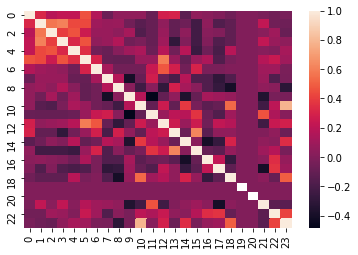

In [148]:
ax = seaborn.heatmap(m)
plt.show()

In [149]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.038714462763836055

As my results are ordered rather than categorical here, it would be useful to compute Cohen's weighted kappa as well.

In [150]:
cohens_weighted_kappa(anno.annotations[:,3], anno.annotations[:,9])

-0.1351351351351353

For these two coders, Cohen's weighted kappa is larger in magnitude than the unweighted statistic. This makes sense, as this value ascribes greater disagreement between ratings of 2 and 5 than between ratings of 2 and 3 and thus reflects the magnitude of disagreement between the coders.

Here is Cohen's weighted kappa averaged over the toal responses. This value is again very low, reflecting the disagreement among coders.

In [151]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.0904630370108133

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


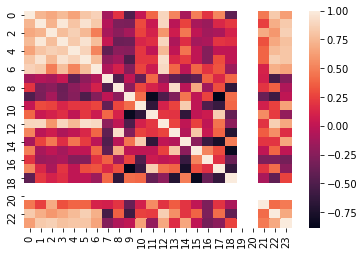

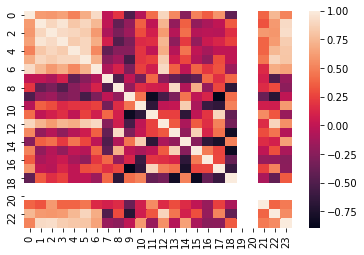

In [152]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

In [153]:
# averaged over comparable pairs
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.18001215441568394 0.16934044744204274


The above matrices reflect the tendency with which coders' scores tend to change together. The uniformity in the top left of these Pearson's rho and Spearman's rho matrices (where the first seven coders are compared to each other) is likely due to my sampling strategy. Before posting the survey on MTurk, I sent it out to people in my personal network, most of whom are similar in terms of levels of education and political ideology. Thus, it is likely that those individuals would have similar perceptions of how much statements prioritized fighting climate change. Obviously, this was just a toy example of a survey, and such a sampling strategy would not yield generalizable results. Among the MTurk Sample (coders 7 onward), there is a lot less uniformity in the extent to which coders' responses tend to vary with one another as evidenced by the darker colors indicating lower values. The individual and averaged values for the two metrics are very similar, which makes sense given the linear nature of the ratings. Users 19 and 20 both gave ratings of all 2s and all 4s respectively to every speaker (as shown below) and thus have no variation in ratings, which is why there are gaps in the matrix corresponding to those users.

In [198]:
anno.annotations[:, 19]

array([2, 2, 2, 2, 2, 2, 2])

In [199]:
anno.annotations[:, 20]

array([4, 4, 4, 4, 4, 4, 4])

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides three relevant models: ModelA, ModelB, and ModelBt. Model A can only be currently run on a balanced 8-coder design, but assesses accuracy purely based on agreement. Model B with $\theta$s models the relationship between each coder and code. Model B is the Dawid & Skene model from the reading. The following image schematically suggests the relationship between the models. <img src="../data/models.png">

The models should provide similar results. To estimate the parameters for any models, we first need to create a new model. 

In [108]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [109]:
# create a new instance of model A, with 4 label classes
model = ModelB.create_initial_state(4, 8)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.79781664 0.08788052 0.04602549 0.06827735]
  [0.03523295 0.64824183 0.11977775 0.19674747]
  [0.05229883 0.09064336 0.75592151 0.10113631]
  [0.06712386 0.01852125 0.24512929 0.66922561]]

 [[0.62875082 0.20686374 0.10058563 0.06379981]
  [0.2674915  0.54240563 0.09745198 0.09265089]
  [0.05265325 0.07027558 0.70401615 0.17305502]
  [0.07300511 0.06803583 0.15439362 0.70456545]]

 [[0.63896176 0.22615321 0.06445538 0.07042965]
  [0.17914508 0.50099601 0.25741949 0.06243942]
  [0.05661295 0.1025089  0.67176044 0.16911771]
  [0.02751668 0.14484278 0.17986965 0.6477709 ]]

 [[0.84396256 0.04951867 0.10290923 0.00360954]
  [0.10185389 0.61576236 0.26029944 0.02208432]
  [0.11940035 0.09202366 0.69041081 0.09816518]
  [0.21581541 0.10570126 0.14533966 0.53314368]]

 [[0.70771465 0.12239118 0.15628836 0.01360581]
  [0.11478505 0.74907197 0.1072611  0.02888188]
  [0.17525635 0.13302602 0.58353767 0.10817996]
  [0.05163449 0.0223604  0.33843488 0.58757024]]

 [[0.7265637  0.14263881 0.072

In [110]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

Pyanno allows one to use either MLE (maximum likelihood estimation) or MAP (maximum a posteriori estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator.

In [111]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

In [112]:
model = ModelB.create_initial_state(4, 8)
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [113]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.20741380e-42 1.00240780e-01 7.90821679e-01 1.08937540e-01]
 [9.92682453e-01 7.07056554e-03 2.46981317e-04 2.03944498e-49]
 [1.07420297e-03 5.51435353e-02 9.37476514e-01 6.30574822e-03]
 ...
 [8.15378491e-04 3.51193436e-02 9.59859130e-01 4.20614824e-03]
 [1.34481992e-44 2.14447325e-03 9.16166870e-01 8.16886569e-02]
 [2.14745550e-01 7.69057353e-01 1.61970966e-02 2.01807019e-26]]


Let's turn the posterior of the first 100 samples into a heatmap.

In [114]:
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

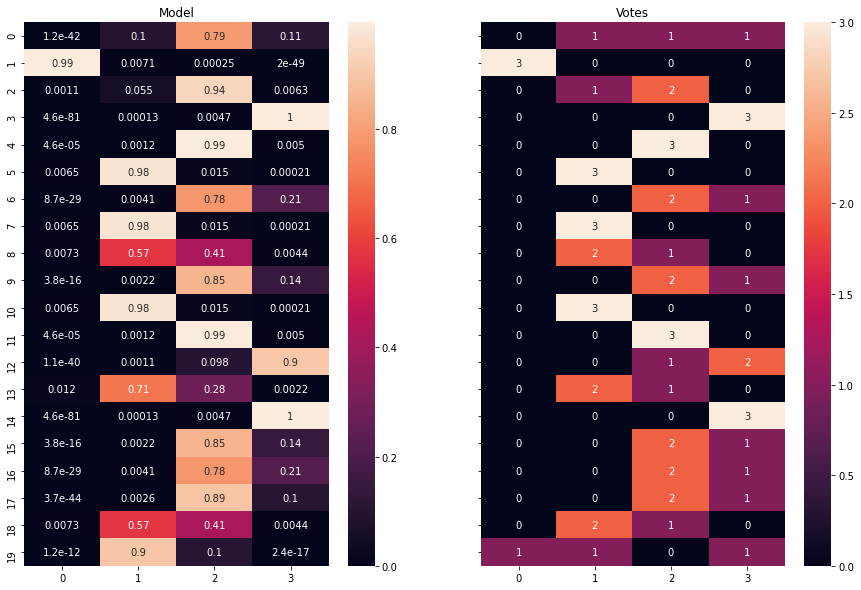

In [115]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 20

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

This differs markedly from taking annotator scores at face value (Add comparison of average values)

In [116]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [117]:
print(samples[0].mean(axis=0))
print(samples[0].std(axis=0))

[[[0.72760972 0.20586578 0.04898071 0.01754379]
  [0.14625936 0.6902161  0.09507237 0.06845217]
  [0.02714071 0.1531038  0.68300962 0.13674587]
  [0.01124114 0.03236379 0.09928043 0.85711463]]

 [[0.66675302 0.21070736 0.09241507 0.03012455]
  [0.13677993 0.68725398 0.12514478 0.05082131]
  [0.03510038 0.16195137 0.6634841  0.13946415]
  [0.01138044 0.06529327 0.13450452 0.78882177]]

 [[0.78690437 0.14458969 0.0487914  0.01971454]
  [0.10340346 0.74682548 0.10652858 0.04324247]
  [0.06508415 0.1336549  0.69331669 0.10794426]
  [0.01506818 0.06379153 0.21887187 0.70226842]]

 [[0.6648655  0.26683498 0.04918282 0.0191167 ]
  [0.10083274 0.7379538  0.11949416 0.04171929]
  [0.02665795 0.14693475 0.67086515 0.15554215]
  [0.00815294 0.03852595 0.23721309 0.71610801]]

 [[0.76132935 0.13972958 0.07957999 0.01936108]
  [0.12638083 0.67136828 0.15299376 0.04925713]
  [0.01869721 0.21701047 0.63757491 0.1267174 ]
  [0.00840992 0.07098937 0.18385429 0.73674642]]

 [[0.7273644  0.21166855 0.041

Let's try everything again with ModelBt

In [118]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.60041426 0.82273618 0.81863081 0.67600359 0.9265776  0.93464181
 0.91791107 0.78178345]
-3245.8466568145022


In [119]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.79127818 0.74082878 0.76222189 0.72517627 0.71644762 0.71855439
 0.77321228 0.71666315]
-2811.9462262249745


In [120]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.01110562 0.28927076 0.36504222 0.3345814 ]
 [0.99022771 0.00241796 0.00404685 0.00330748]
 [0.00250003 0.05506243 0.93460552 0.00783202]
 ...
 [0.00252941 0.0439574  0.94558913 0.00792406]
 [0.00249439 0.00571273 0.93249681 0.05929607]
 [0.03189373 0.93882796 0.0161109  0.0131674 ]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

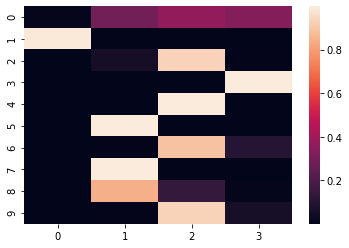

In [121]:
ax = seaborn.heatmap(posterior[:10,])
plt.show()

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. For some analyses, we may simply use the posterior themselves rather than the most probably code outcome.

# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [122]:
model = ModelBt.create_initial_state(4, 3, theta=[0.99,0.75,0.25])
#randome generate annotations with 4 label classes and 3 annotators. The accuracy of the three annotators are 0.99, 0.75, and 0.25 respectively.
model.generate_annotations(20)

array([[0, 1, 3],
       [3, 3, 0],
       [2, 2, 3],
       [0, 3, 1],
       [2, 2, 3],
       [1, 1, 0],
       [1, 1, 1],
       [0, 0, 3],
       [3, 3, 1],
       [2, 2, 1],
       [1, 1, 3],
       [3, 3, 0],
       [1, 0, 0],
       [2, 2, 3],
       [1, 1, 2],
       [2, 2, 2],
       [2, 3, 2],
       [2, 0, 2],
       [2, 2, 1],
       [1, 1, 0]])

## Visualizing coder accuracy

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipython notebooks. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [123]:
model = ModelBt.create_initial_state(4, 8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

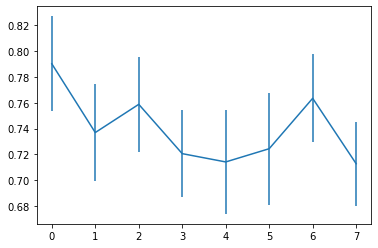

In [124]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Example with articles that use the General Social Survey

I performed a recent study in which the variables from thousands of articles were associated with those used in the General Social Survey, a widely used population sample, in order to interrogate how social science analyses are performed. Each article was reread and coded by a balanced set of three student coders using a 6 choose 3 design, such that all possible 3-coder-subsets (20) coded an equal number of articles. Coding was performed through a website that allowed students access to the digital article. To evaluate the validity of the student codes, we also recruited a sample of authors associated with 97 of our published articles to fill out the same online survey. 

Because not all coders coded items with equal accuracy, and because “don’t know” was an optional answer, leading to potential ties, we used a generative, probabilistic model to estimate the maximum a posteriori probability (MAP) prediction that an item’s code is true, which integrates over the estimated accuracy of coders, assuming only that the entire population of coders is slightly more often right than wrong. The model (“Model B”) is based on a simple underlying generation process that directly accounts for the probability that coded values are correct (Rzhetsky et al. 2009). For each coded value j, a set of parameters, denoted γj, represents the probability that each coded value is correct. For the ith coder (i = 1, 2, …, 6), we introduce a matrix of probabilities, denoted λ(i)x|y, that defines the probability that she assigns code x (e.g., Dependent variable) to a GSS variable with correct annotation y. For a perfect coder, the matrix λ(i)x|y would equal the identity matrix and her vote would count most toward the total. For a coder that always codes incorrectly—a “troll”—her matrix λ(i)x|y will have all its value off the diagonal and will only minimally influence the posterior. We co-authored the open source pyanno software that implements this model.

Getting the data for each content analysis survey regarding how GSS variables were used in a large population of social science articles.

In [46]:
#anno_vdep = AnnotationsContainer.from_file(missing_values=[-1], filename="GSSvariable_testSdependent.csv")
dev = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testSdependent.csv", dtype=int, delimiter=",")
anno_dv = AnnotationsContainer.from_array(dev)

ind = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testSindependent.csv", dtype=int, delimiter=",")
anno_iv = AnnotationsContainer.from_array(ind)

cent = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testScentral.csv", dtype=int, delimiter=",")
anno_cv = AnnotationsContainer.from_array(cent)

cont = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testScontrol.csv", dtype=int, delimiter=",")
anno_ctv = AnnotationsContainer.from_array(cont)

test = np.loadtxt(fname="../data/dataforgssstudy/testH.csv", dtype=int, delimiter=",")
anno_test = AnnotationsContainer.from_array(test)

Let's examine the data structure.

In [47]:
dev.shape

(21461, 6)

In [48]:
anno_dv.labels

[0, 1]

In [49]:
anno_dv.missing_values

[-1]

In [50]:
anno_dv.annotations.shape

(21461, 6)

First, let's use Cohen's $\kappa$ to measure agreement between coders...

In [51]:
m = pairwise_matrix(cohens_kappa, anno_dv.annotations)
print(m)

[[1.         0.62426874 0.46682841 0.44599604 0.16569888 0.36657805]
 [0.62426874 1.         0.53480937 0.52673854 0.3306905  0.59513211]
 [0.46682841 0.53480937 1.         0.50580068 0.42393752 0.49833997]
 [0.44599604 0.52673854 0.50580068 1.         0.46517493 0.47023754]
 [0.16569888 0.3306905  0.42393752 0.46517493 1.         0.66190749]
 [0.36657805 0.59513211 0.49833997 0.47023754 0.66190749 1.        ]]


Let's visualize that...

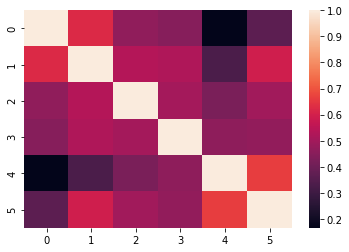

In [52]:
ax = seaborn.heatmap(m)
plt.show()

In [53]:
pairwise_metric_average(cohens_kappa, anno_dv.annotations)

0.4721425844540702

Let's compute the statistics on each of the datasets and with Pearson's $\rho$. 

In [54]:
datasets = [anno_dv.annotations, anno_iv.annotations, anno_cv.annotations, anno_ctv.annotations]
ck = [pairwise_matrix(cohens_kappa, anno) for anno in datasets]
pr = [pairwise_matrix(pearsons_rho, anno) for anno in datasets]
titles = ['DV', 'IV', 'Central Variable', "Control Variable"]

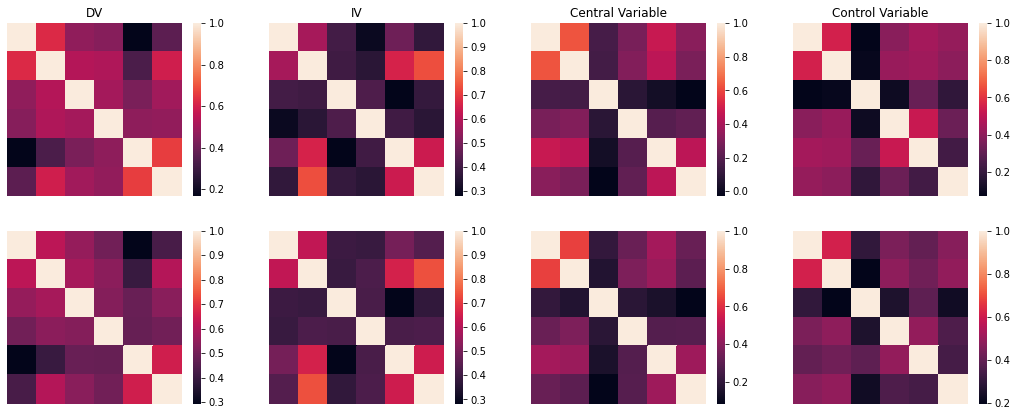

In [55]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(18, 7)
for k, ax, title in zip(ck,axs[0], titles):
    seaborn.heatmap(k, ax = ax)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())
for r, ax in zip(pr,axs[1]):
    seaborn.heatmap(r, ax = ax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

Now we will compare the student coders.

In [56]:
nondiag = (np.eye(6)-np.ones(6))*-1.0

In [57]:
xdevck = pairwise_matrix(cohens_kappa, anno_dv.annotations)
xdevpr = pairwise_matrix(pearsons_rho, anno_dv.annotations)

xindck = pairwise_matrix(cohens_kappa, anno_iv.annotations)
xindpr = pairwise_matrix(pearsons_rho, anno_iv.annotations)

xcenck = pairwise_matrix(cohens_kappa, anno_cv.annotations)
xcenpr = pairwise_matrix(pearsons_rho, anno_cv.annotations)

xconck = pairwise_matrix(cohens_kappa, anno_ctv.annotations)
xconpr = pairwise_matrix(pearsons_rho, anno_ctv.annotations)

print(np.average(xdevck, weights=nondiag))
print(np.average(xdevpr, weights=nondiag))
print(np.average(xindck, weights=nondiag))
print(np.average(xindpr, weights=nondiag))
print(np.average(xcenck, weights=nondiag))
print(np.average(xcenpr, weights=nondiag))
print(np.average(xconck, weights=nondiag))
print(np.average(xconpr, weights=nondiag))

0.47214258445407015
0.5142407278222342
0.4529627823703711
0.47596526866863437
0.27082376869768193
0.31514049828362706
0.32833477875850064
0.3945852779196347


Now we are going to bring in "gold standard" data. In this case, this is where we asked authors of the articles to code their own article's variables and compare with our student coders.

In [58]:
mergedata = np.loadtxt(fname="../data/dataforgssstudy/gss_mergedataC.txt", dtype=int, delimiter="\t")

In [59]:
anno_merge_dep = AnnotationsContainer.from_array(mergedata[:,0:2])
anno_merge_ind = AnnotationsContainer.from_array(mergedata[:,2:4])
anno_merge_cen = AnnotationsContainer.from_array(mergedata[:,4:6])
anno_merge_con = AnnotationsContainer.from_array(mergedata[:,6:8])
anno_merge_dkn = AnnotationsContainer.from_array(mergedata[:,8:10])

In [60]:
print("""Dependent variable -- kappa & rho""")
print(cohens_kappa(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))
print(pearsons_rho(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))

print("\nIndependent variable")
print(cohens_kappa(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))
print(pearsons_rho(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))

print("\nCentral variable")
print(cohens_kappa(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))
print(pearsons_rho(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))

print("\nControl variable")
print(cohens_kappa(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))
print(pearsons_rho(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))

Dependent variable -- kappa & rho
0.3744311057948666
0.38563437203620615

Independent variable
0.5430690164641346
0.5529974941771468

Central variable
-0.064017189548477
-0.08887644319259187

Control variable
0.2815172499181942
0.28239237574620263


Whoah! Student coders and authors viewed articles that were "central" or critical to the published argument as fundamentally different (exhibiting negative agreement and correlation). Why? Likely because that researchers recalled what they had _intended_ as their central variables before analysis, but those that _worked out_ became central in the text.

Now for the assessment of the relative values of authors, then student coders.

In [61]:
print("Dependent")
print(np.average(anno_merge_dep.annotations[:,0]))
print(np.average(anno_merge_dep.annotations[:,1]))

print("\nIndependent")
print(np.average(anno_merge_ind.annotations[:,0]))
print(np.average(anno_merge_ind.annotations[:,1]))

print("\nCentral")
print(np.average(anno_merge_cen.annotations[:,0]))
print(np.average(anno_merge_cen.annotations[:,1]))

print("\nControl")
print(np.average(anno_merge_con.annotations[:,0]))
print(np.average(anno_merge_con.annotations[:,1]))

Dependent
0.4763912310286678
0.35834738617200673

Independent
0.23777403035413153
0.3136593591905565

Central
0.35328836424957843
0.7512647554806071

Control
0.081787521079258
0.09443507588532883


## Now we are going to use models to predict the correct annotations

Recall that Model A is built for 8 coders, but we have 6. We're going to *hack* it by adding two blank columns.

In [62]:
dev.shape

(21461, 6)

In [63]:
negs2 = np.ones((21461, 2), dtype=np.int)*(-1)
devA = np.concatenate((dev, negs2), axis=1)
devA

array([[ 0, -1, -1, ...,  1, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [64]:
anno_dvA = AnnotationsContainer.from_array(devA)
model_devA = ModelA.create_initial_state(2)
model_devA.theta

array([0.65595567, 0.85435077, 0.75426342, 0.77533797, 0.89258464,
       0.80295383, 0.82581862, 0.64518064])

In [65]:
model_dvB = ModelB.create_initial_state(2, 6)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[0.13942018 0.86057982]
-45357.92065827822


In [66]:
model_dvB.map(anno_dv.annotations)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[0.69455487 0.30544513]
-25462.473635032595


In [68]:
# compute the posterior distribution over true annotations
posterior_dvB = model_dvB.infer_labels(anno_dv.annotations)
# each row show the probability of each label class for the
# corresponding item
print(posterior_dvB)

[[0.05096941 0.94903059]
 [0.99531886 0.00468114]
 [0.82315887 0.17684113]
 ...
 [0.97178066 0.02821934]
 [0.97178066 0.02821934]
 [0.97178066 0.02821934]]


In [69]:
samples_dvB = model_dvB.sample_posterior_over_accuracy(anno_dv.annotations, 200, burn_in_samples=100, thin_samples=3)

In [70]:
# we can then compute a credible interval for the parameters:
ci_dv_mean = samples_dvB[0].mean(axis=0)
print("Mean")
print(ci_dv_mean)

ci_dv_stdev = samples_dvB[0].std(axis=0)
print("\nSTD")
print(ci_dv_stdev)


Mean
[[[0.97935867 0.02064133]
  [0.51451591 0.48548409]]

 [[0.96910373 0.03089627]
  [0.25735677 0.74264323]]

 [[0.98241403 0.01758597]
  [0.34583088 0.65416912]]

 [[0.93428394 0.06571606]
  [0.24128009 0.75871991]]

 [[0.69302737 0.30697263]
  [0.04567475 0.95432525]]

 [[0.86374774 0.13625226]
  [0.06854737 0.93145263]]]

STD
[[[0.0023367  0.0023367 ]
  [0.01158411 0.01158411]]

 [[0.00330487 0.00330487]
  [0.012625   0.012625  ]]

 [[0.00322762 0.00322762]
  [0.01488924 0.01488924]]

 [[0.00468783 0.00468783]
  [0.01187478 0.01187478]]

 [[0.00664532 0.00664532]
  [0.00578484 0.00578484]]

 [[0.00694089 0.00694089]
  [0.00696025 0.00696025]]]


We will use Model B estimates for other variable assessments.

In [71]:
#test
model_testB = ModelB.create_initial_state(2, 6)
print(model_testB.log_likelihood(anno_test.annotations))
model_testB.map(anno_test.annotations)
print(model_testB.pi)
print(model_testB.log_likelihood(anno_test.annotations))
print(anno_test.annotations.shape)
posterior_testB = model_testB.infer_labels(anno_test.annotations)
print(posterior_testB.shape)
samples_testB = model_testB.sample_posterior_over_accuracy(anno_test.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_test_mean = samples_testB[0].mean(axis=0)
print(ci_test_mean)

-102.66019608083538
[9.20933481e-20 1.00000000e+00]
-48.9756711393957
(48, 6)
(48, 2)
[[[0.80916179 0.19083821]
  [0.12433786 0.87566214]]

 [[0.80041129 0.19958871]
  [0.08766934 0.91233066]]

 [[0.80268724 0.19731276]
  [0.49303008 0.50696992]]

 [[0.79034387 0.20965613]
  [0.07053921 0.92946079]]

 [[0.80696846 0.19303154]
  [0.35750611 0.64249389]]

 [[0.79781228 0.20218772]
  [0.12379765 0.87620235]]]


In [ ]:
#indepedent variables
model_ivB = ModelB.create_initial_state(2, 6)
print(model_ivB.log_likelihood(anno_iv.annotations))
model_ivB.map(anno_iv.annotations)
print(model_ivB.pi)
print(model_ivB.log_likelihood(anno_iv.annotations))
print(anno_iv.annotations.shape)
posterior_ivB = model_ivB.infer_labels(anno_iv.annotations)
print(posterior_ivB.shape)
samples_ivB = model_ivB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_iv_mean = samples_ivB[0].mean(axis=0)
print(ci_iv_mean)

#central variables
model_cvB = ModelB.create_initial_state(2, 6)
print(model_cvB.log_likelihood(anno_cv.annotations))
model_cvB.map(anno_cv.annotations)
print(model_cvB.pi)
print(model_cvB.log_likelihood(anno_cv.annotations))
print(anno_cv.annotations.shape)
posterior_cvB = model_cvB.infer_labels(anno_cv.annotations)
print(posterior_cvB.shape)
samples_cvB = model_cvB.sample_posterior_over_accuracy(anno_cv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_cv_mean = samples_cvB[0].mean(axis=0)
print(ci_cv_mean)

#control variables
model_ctvB = ModelB.create_initial_state(2, 6)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
model_ctvB.map(anno_ctv.annotations)
print(model_ctvB.pi)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
print(anno_ctv.annotations.shape)
posterior_ctvB = model_ctvB.infer_labels(anno_ctv.annotations)
print(posterior_ctvB.shape)
samples_ctvB = model_ctvB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_ctv_mean = samples_ctvB[0].mean(axis=0)
print(ci_ctv_mean)

-47319.23422199592
[0.61093546 0.38906454]
-28620.66523246587
(21461, 6)
(21461, 2)
[[[0.97058631 0.02941369]
  [0.34535284 0.65464716]]

 [[0.93614856 0.06385144]
  [0.05216538 0.94783462]]

 [[0.65774549 0.34225451]
  [0.2100162  0.7899838 ]]

 [[0.53436752 0.46563248]
  [0.02994546 0.97005454]]

 [[0.87419426 0.12580574]
  [0.09754048 0.90245952]]

 [[0.88988875 0.11011125]
  [0.08766415 0.91233585]]]
-29891.610747435112
[0.23988844 0.76011156]
-25034.918555765576
(21461, 6)
(21461, 2)
[[[0.89185641 0.10814359]
  [0.06916033 0.93083967]]

 [[0.78531668 0.21468332]
  [0.05758459 0.94241541]]

 [[0.99214351 0.00785649]
  [0.84173253 0.15826747]]

 [[0.95016528 0.04983472]
  [0.45644392 0.54355608]]

 [[0.67451899 0.32548101]
  [0.0573835  0.9426165 ]]

 [[0.58901899 0.41098101]
  [0.09572239 0.90427761]]]
-22350.990364728656
[0.83068326 0.16931674]
-19415.702035242168
(21461, 6)
(21461, 2)


Now we will package up the predicted data into a format we can use for other, subsequent analysis:

In [173]:
print(posterior_dvB.shape)
print(posterior_ivB.shape)
print(posterior_cvB.shape)
print(posterior_ctvB.shape)

(21461, 2)
(21461, 2)
(21461, 2)
(21461, 2)


In [174]:
predicted_annotations = np.concatenate((posterior_dvB, posterior_ivB, posterior_cvB, posterior_ctvB), axis=1) # posterior_dvBt, posterior_ivBt, posterior_cvBt, posterior_ctvBt), axis=1)

In [175]:
predicted_annotations.shape

(21461, 8)

These annotations allowed us to uncover the degree to which social scientists alter their models to achieve a better fit...undocumented data mining. The answer was that social scientists did mine their data, but that it likely improved their analysis because change in the social world was the result of greater distortion than undocumented data mining.

## Another example analysis looks at a different data set of Hotel Reviews by a variety of patrons.

In [176]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

,Karen,Scott,Jessica,write a review,A verified traveler,Kevin,William,R,S,Christopher,...,Thomas,Susan,A Traveler,M,Not Provided,B,Laura,xxxxxxxxxxxxxx,Michael,Joseph
1785 Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900 House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bed & Breakfast In Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Swallow's Nest Motel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abbeville Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [177]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values

And we can visualize all the reviews as a heatmap with the missing values greyed out

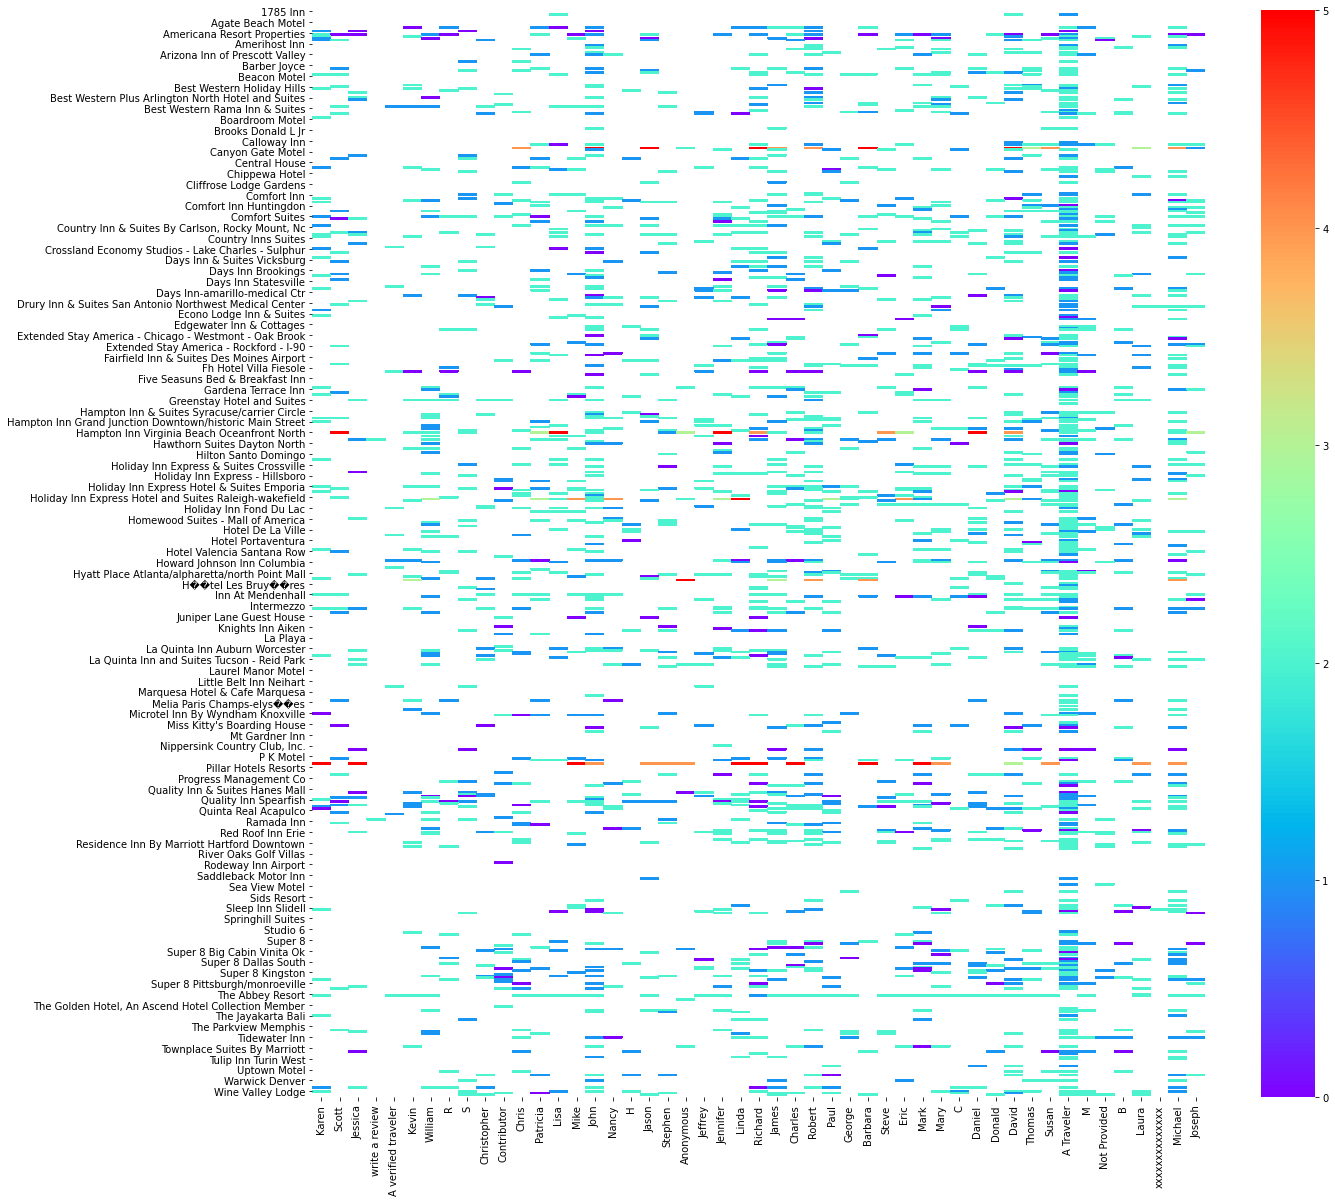

In [178]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [181]:
hot_mat = np.array(df_hotels.fillna(-1))
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [182]:
anno_hot.annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [183]:
anno_hot.labels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [184]:
anno_hot.missing_values

[-1]

Look at coder agreement

In [185]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

array([0.07806534, 0.26262198, 0.63555367, 0.00636402, 0.0093339 ,
       0.00806109])

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


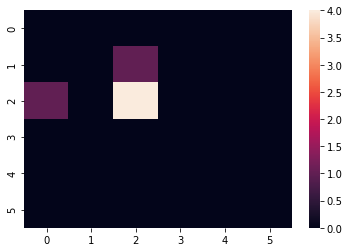

In [186]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [187]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.3787878787878787

In [188]:
krippendorffs_alpha(anno_hot.annotations[::])

0.398760907615921

In [189]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.40328336902212697

/opt/anaconda3/lib/python3.7/site-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


<AxesSubplot:>

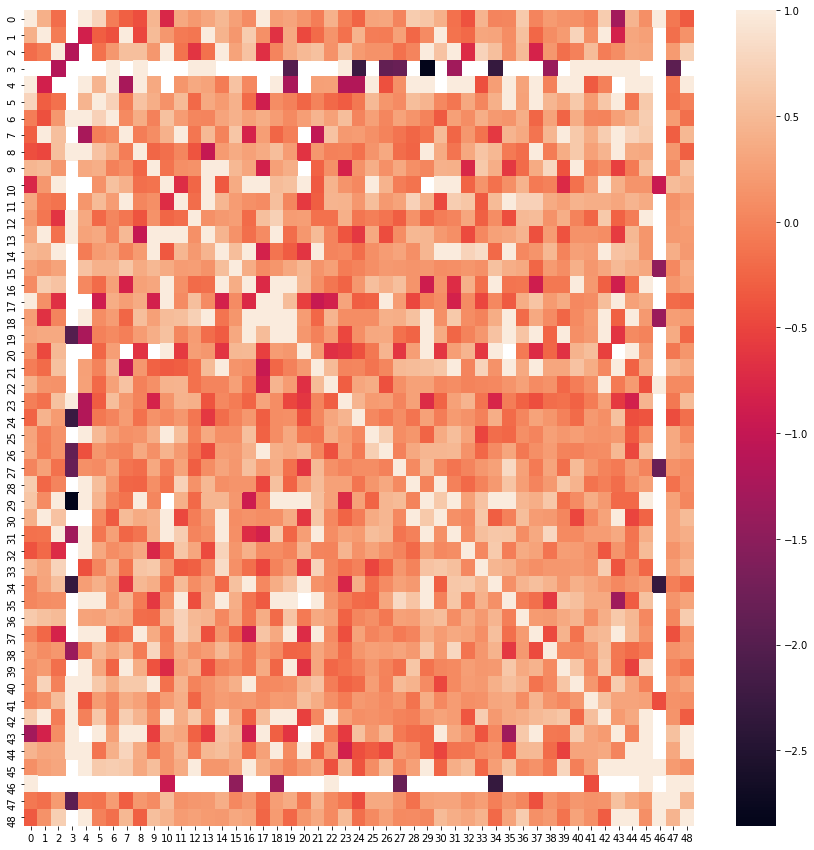

In [190]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

In [191]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

[8.07982630e-01 6.45491112e-01 6.75797261e-01 8.05643142e-01
 5.58613639e-01 9.99999983e-01 6.40094602e-01 3.18280967e-01
 5.62642161e-01 4.57156149e-01 4.80660261e-01 4.60836488e-01
 8.52613150e-01 4.98855773e-01 2.26613627e-01 2.87544029e-01
 7.36378006e-01 3.91812658e-01 3.05899149e-01 1.93833949e-07
 3.54628713e-01 6.55429852e-01 7.03454209e-01 5.00664448e-01]
-2707.565352860008


In [192]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<Figure size 1080x720 with 4 Axes>,
 (<AxesSubplot:title={'center':'Model'}>,
  <AxesSubplot:title={'center':'Votes'}>))

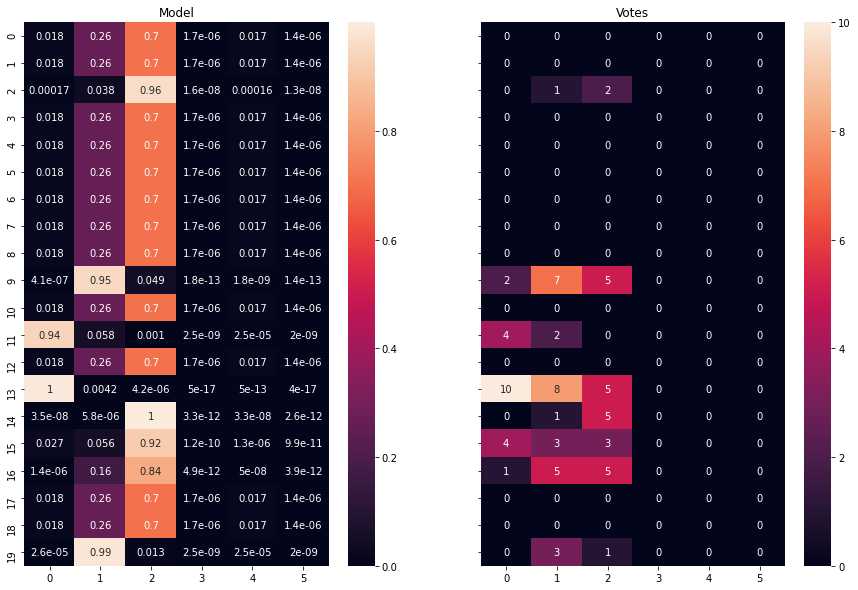

In [193]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

Let's start with model B.

In [154]:
model = ModelB.create_initial_state(5, 24)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.51396918e-01 9.63936022e-02 4.54940419e-02 7.24814319e-03
   9.94672950e-02]
  [1.84774604e-01 5.68349789e-01 2.12844906e-01 1.87929106e-02
   1.52377900e-02]
  [5.80364369e-02 1.94745592e-01 4.34173727e-01 2.02357653e-01
   1.10686591e-01]
  [1.09783308e-02 1.07738831e-01 2.14737116e-01 5.29319168e-01
   1.37226555e-01]
  [1.64545994e-02 1.73366003e-01 2.70924016e-02 2.33296803e-01
   5.49790193e-01]]

 [[7.24767685e-01 1.34308338e-01 9.42337500e-02 1.98496511e-02
   2.68405757e-02]
  [1.31212497e-01 6.54169285e-01 1.15358117e-01 8.74372897e-02
   1.18228116e-02]
  [3.29329287e-02 2.50846086e-01 5.68576828e-01 1.08991107e-01
   3.86530507e-02]
  [5.30155870e-03 4.31147651e-02 7.17912222e-02 7.78620551e-01
   1.01171903e-01]
  [1.42485568e-02 3.87998639e-03 1.18279603e-01 2.08826819e-01
   6.54765034e-01]]

 [[6.48312623e-01 2.19089507e-01 7.85130417e-02 7.66021897e-03
   4.64246089e-02]
  [2.10856880e-01 5.58418805e-01 2.10522171e-01 1.17830928e-02
   8.41905109e-03]
  [1.6688920

In [155]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 
                        200, burn_in_samples=100, thin_samples=3)

In [156]:
print(samples[0].mean(axis=0))
print(samples[0].std(axis=0))

[[[0.67708047 0.16395209 0.08428918 0.03341091 0.04126735]
  [0.14983768 0.59237715 0.15034778 0.07271507 0.03472232]
  [0.07522023 0.14482364 0.56539594 0.14559387 0.06896632]
  [0.05998143 0.06112404 0.21550776 0.54059502 0.12279175]
  [0.04004209 0.03929492 0.07620451 0.17252987 0.67192861]]

 [[0.68362736 0.16637988 0.07199207 0.03921465 0.03878604]
  [0.14039191 0.59045202 0.15564858 0.07528622 0.03822127]
  [0.07196722 0.14699128 0.5650633  0.14264657 0.07333163]
  [0.09242943 0.06056407 0.11995492 0.51743818 0.2096134 ]
  [0.04511716 0.03781828 0.07836512 0.16933001 0.66936942]]

 [[0.68095616 0.15950756 0.07631005 0.04274146 0.04048478]
  [0.15292308 0.59044729 0.15307444 0.06523323 0.03832196]
  [0.07770889 0.14230761 0.57079676 0.14183004 0.06735671]
  [0.06051081 0.09567675 0.12365889 0.49799854 0.22215501]
  [0.04930725 0.03963297 0.07857027 0.17099093 0.66149857]]

 [[0.64299632 0.19691104 0.08113525 0.03945564 0.03950175]
  [0.14442712 0.59296916 0.14896614 0.07383352 0.0

In [157]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.8        0.15       0.05       0.         0.        ]
  [0.13636364 0.68181818 0.13636364 0.04545455 0.        ]
  [0.04347826 0.13043478 0.65217391 0.13043478 0.04347826]
  [0.03571429 0.03571429 0.21428571 0.60714286 0.10714286]
  [0.         0.         0.05263158 0.15789474 0.78947368]]

 [[0.8        0.15       0.05       0.         0.        ]
  [0.13636364 0.68181818 0.13636364 0.04545455 0.        ]
  [0.04347826 0.13043478 0.65217391 0.13043478 0.04347826]
  [0.07142857 0.03571429 0.10714286 0.57142857 0.21428571]
  [0.         0.         0.05263158 0.15789474 0.78947368]]

 [[0.8        0.15       0.05       0.         0.        ]
  [0.13636364 0.68181818 0.13636364 0.04545455 0.        ]
  [0.04347826 0.13043478 0.65217391 0.13043478 0.04347826]
  [0.03571429 0.07142857 0.10714286 0.57142857 0.21428571]
  [0.         0.         0.05263158 0.15789474 0.78947368]]

 [[0.75       0.2        0.05       0.         0.        ]
  [0.13636364 0.68181818 0.13636364 0.04545455 0. 

/opt/anaconda3/lib/python3.7/site-packages/pyanno/util.py:80: RuntimeWarning: divide by zero encountered in log
  log_theta = ninf_to_num(log(theta))


In [158]:
model = ModelB.create_initial_state(5, 24)
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.8        0.15       0.05       0.         0.        ]
  [0.13636364 0.68181818 0.13636364 0.04545455 0.        ]
  [0.04347826 0.13043478 0.65217391 0.13043478 0.04347826]
  [0.03571429 0.03571429 0.21428571 0.60714286 0.10714286]
  [0.         0.         0.05263158 0.15789474 0.78947368]]

 [[0.8        0.15       0.05       0.         0.        ]
  [0.13636364 0.68181818 0.13636364 0.04545455 0.        ]
  [0.04347826 0.13043478 0.65217391 0.13043478 0.04347826]
  [0.07142857 0.03571429 0.10714286 0.57142857 0.21428571]
  [0.         0.         0.05263158 0.15789474 0.78947368]]

 [[0.8        0.15       0.05       0.         0.        ]
  [0.13636364 0.68181818 0.13636364 0.04545455 0.        ]
  [0.04347826 0.13043478 0.65217391 0.13043478 0.04347826]
  [0.03571429 0.07142857 0.10714286 0.57142857 0.21428571]
  [0.         0.         0.05263158 0.15789474 0.78947368]]

 [[0.75       0.2        0.05       0.         0.        ]
  [0.13636364 0.68181818 0.13636364 0.04545455 0. 

Once we map the annotations onto the model, we see that log likelihood improves.

In [159]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.00000000e+00 0.00000000e+00 3.41597176e-78 1.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.86627670e-74 1.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.47497802e-74 1.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.64998535e-71 1.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.22657058e-71 1.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.00569256e-79 1.00000000e+00
  5.70847286e-76]
 [1.00000000e+00 0.00000000e+00 8.47193772e-74 0.00000000e+00
  0.00000000e+00]]


In [160]:
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

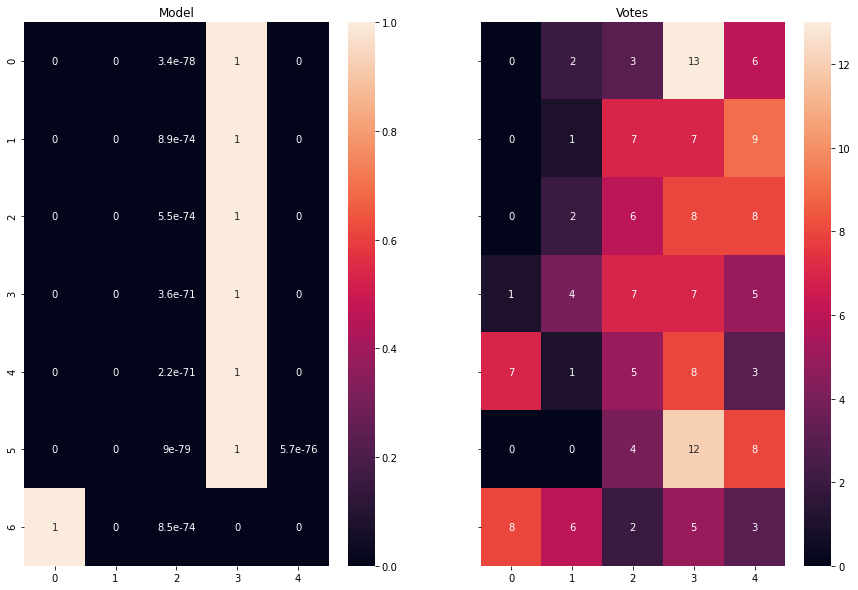

In [161]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 7

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

The above Model B predicts what the correct answer 'should' be based on conditional aggregations of coders' responses to the quesitons. It is interesting to me that the model predicts a score of 4 (3 on the matrix, which is zero-indexed) corresponding to high-priority for each of the speeches except for Trump's, for which it predicts a 1. Only in rows 1, 4, and 5 does the third column get a clear majority of votes, so this is where the model relies on how much voters agree with other voters for particular questions more than it relies on majority votes. I wonder if these results would still hold with more than 24 coders generating these responses, or if the model would pick up more on subtleties of ratings for each speech.

Now let's compare the above to just average values.

In [162]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [163]:
print(samples[0].mean(axis=0))
print(samples[0].std(axis=0))

[[[0.67540313 0.15793679 0.08187851 0.04476196 0.04001961]
  [0.1637012  0.57226333 0.15143672 0.0755626  0.03703615]
  [0.07278011 0.14813038 0.56699659 0.14569842 0.0663945 ]
  [0.05883195 0.0642339  0.20701384 0.54646711 0.1234532 ]
  [0.0431557  0.04179092 0.08007021 0.16507205 0.66991112]]

 [[0.66940419 0.16055293 0.0839549  0.04156682 0.04452116]
  [0.15124489 0.59314706 0.14283332 0.07426609 0.03850864]
  [0.07415216 0.14501855 0.57358795 0.14026064 0.06698071]
  [0.09621747 0.05931519 0.11612395 0.51063854 0.21770486]
  [0.04440344 0.03766333 0.07842724 0.17316611 0.66633988]]

 [[0.68425538 0.16320036 0.07628195 0.03929868 0.03696363]
  [0.15051909 0.58533126 0.14780005 0.08151097 0.03483863]
  [0.0741487  0.14440586 0.56664266 0.14428161 0.07052118]
  [0.06122089 0.09280662 0.1206355  0.52501974 0.20031724]
  [0.03964055 0.04195399 0.0852843  0.16522155 0.6678996 ]]

 [[0.6397594  0.19852306 0.08257227 0.04101744 0.03812782]
  [0.14595005 0.59832702 0.14401894 0.07283281 0.0

Now let's repeat the process using Model B with theta.

In [164]:
# create a new instance of model B, with 5 label classes and 24 annotators.
model = ModelBt.create_initial_state(5, 24)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.82573371 0.82936692 0.63105303 0.63892594 0.68565653 0.83953743
 0.80141664 0.79589312 0.91563183 0.74302587 0.90154923 0.72337443
 0.83464733 0.7142832  0.83341421 0.68995005 0.7166425  0.8389792
 0.83659809 0.92422642 0.66777078 0.79556096 0.75832128 0.9024366 ]
-344.11806379587136


In [165]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.70529477 0.73625409 0.68877213 0.740387   0.56998622 0.99999927
 0.62219357 0.42977438 0.34251152 0.50978037 0.55250665 0.4055016
 0.78512601 0.50345273 0.28953277 0.55227926 0.63207211 0.14981056
 0.41902995 0.28973559 0.52390599 0.5887073  0.52057101 0.53336113]
-268.68803831484394


In [166]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.04659485e-14 1.08708897e-13 6.73398359e-18 1.00000000e+00
  9.59083249e-11]
 [1.22821338e-12 1.03733520e-11 1.28104913e-12 1.00205018e-09
  9.99999999e-01]
 [2.46224647e-12 4.36700448e-11 3.37328087e-13 9.99999985e-01
  1.46005438e-08]
 [1.51852382e-09 9.99999819e-01 6.98947721e-11 1.63711624e-07
  1.56650387e-08]
 [9.99999999e-01 1.77693251e-12 2.01281599e-15 5.01420851e-10
  1.66137881e-12]
 [4.64978058e-14 5.71496837e-14 7.98544387e-17 9.99999994e-01
  5.99371411e-09]
 [1.00000000e+00 4.37676154e-10 4.40927225e-17 7.71502806e-12
  2.84039720e-13]]


Now let's plot the first 10 posterior estimates according to Model B with theta.

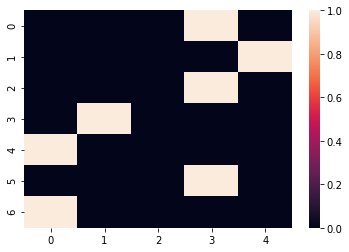

In [202]:
ax = seaborn.heatmap(posterior[:10])
plt.show()

The posterior estimates given by Model B with theta show much more variation in responses than Model B did from earlier (which predicted scores of 3 for the first 6 items). These posterior estimates more closely mirror trends that are visually apparent in the responses. Taking into account the theta values, which represent the extent to which coders agree with other coders for the various questions seems to give us ratings with more variation across speeches than the less interesting predictions of Model B. The individual theta values for the 24 users appear larger in Model Bt than in Model B, yet we see slightly smaller log likelihoods for Model B with theta than for Model B, so there are tradeoffs associated with the different choices of models.

Now we can visualize coder accuracy using our model.

In [170]:
model = ModelBt.create_initial_state(5, 24)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)


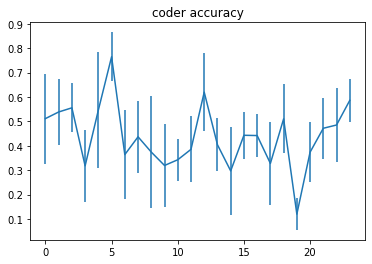

In [172]:
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)
plt.figure()
plt.title('coder accuracy')
plt.errorbar(range(24),y, yerr = y_ci)
plt.show()

It should be noted that the standard deviations here are rather large, so we should interpret any statements about coder accuracy with appropriate caution. It looks like coder accuracy is overall pretty low and there is substantial distribution of skill amongst coders. I wonder if this would change with a larger sample size that might converge more around specific scores for the different speeches. It looks like coder 5 was among the most accurate. I printed their annotations below, and they seem to trend lower than most other annotations, as they only gave one person the maximum score and had 3 ratings on the lower end of the spectrum (whereas many coders in the sample favored the higher end of the ratings spectrum for all speeches). Coder 19 was our probable troll from earlier who gave scores of 2 to every speech and thus has an extremely low accuracy score. Looking at general accuracy could be a good way to screen out unreliable coders. These measures of accuracy also assume that people are right more often than they are wrong, so it would be interesting to compare expert perceptions of how much statements prioritize fighting climate change to our sample's perceptions.

In [200]:
anno.annotations[:, 5]

array([3, 4, 3, 1, 0, 3, 0])

In [201]:
anno.annotations[:, 19]

array([2, 2, 2, 2, 2, 2, 2])